# Bank Loan Prediction

**Libraries that will be used are imported.**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
pd.set_option('float_format','{:f}'.format)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**The dataset is imported and the first five rows are read.**
* __*Reading the columns and first five rows ensures the dataset has been correctly loaded.*__

In [2]:
bank = pd.read_csv('loan.csv')
bank.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,000025bb-5694-4cff-b17d-192b1a98ba44,5ebc8bb1-5eb9-4404-b11b-a6eebc401a19,Fully Paid,11520,Short Term,741.000000,10+ years,Home Mortgage,33694.000000,Debt Consolidation,$584.03,12.300000,41.000000,10,0,6760,16056,0.000000,0.000000
1,00002c49-3a29-4bd4-8f67-c8f8fbc1048c,927b388d-2e01-423f-a8dc-f7e42d668f46,Fully Paid,3441,Short Term,734.000000,4 years,Home Mortgage,42269.000000,other,"$1,106.04",26.300000,nan,17,0,6262,19149,0.000000,0.000000
2,00002d89-27f3-409b-aa76-90834f359a65,defce609-c631-447d-aad6-1270615e89c4,Fully Paid,21029,Short Term,747.000000,10+ years,Home Mortgage,90126.000000,Debt Consolidation,"$1,321.85",28.800000,nan,5,0,20967,28335,0.000000,0.000000
3,00005222-b4d8-45a4-ad8c-186057e24233,070bcecb-aae7-4485-a26a-e0403e7bb6c5,Fully Paid,18743,Short Term,747.000000,10+ years,Own Home,38072.000000,Debt Consolidation,$751.92,26.200000,nan,9,0,22529,43915,0.000000,0.000000
4,0000757f-a121-41ed-b17b-162e76647c1f,dde79588-12f0-4811-bab0-e2b07f633fcd,Fully Paid,11731,Short Term,746.000000,4 years,Rent,50025.000000,Debt Consolidation,$355.18,11.500000,nan,12,0,17391,37081,0.000000,0.000000


# Data Cleaning

### Changing Data Types

**Columns "Maximum Open Credit and "Monthly Debt" have incorrect data types.**<br>
**Attempting to change the data type, it is made apparent the columns have string values that needs to be addressed.**
* _**Column "Maximum Open Credit" has "#VALUE!" values. These are converted to null values.**_ 
* _**Column "Monthly Debt" has "," and "\$" values. These values are removed from the column.**_ <br>

**After addressing the issues, the data types are able to be converted without any further complications.**

In [3]:
print("The data type for column- 'Maximum Open Credit' is {}.".format(bank['Maximum Open Credit'].dtype))
print("The data type for column- 'Monthly Debt' is {}.".format(bank['Monthly Debt'].dtype))

The data type for column- 'Maximum Open Credit' is object.
The data type for column- 'Monthly Debt' is object.


In [4]:
for ind in range(len(bank)) :
    try:
        float(bank.loc[ind,'Maximum Open Credit'])
    except:
        print("Error. Cannot convert '{}' to float.".format(bank.loc[ind,'Maximum Open Credit']))

Error. Cannot convert '#VALUE!' to float.
Error. Cannot convert '#VALUE!' to float.
Error. Cannot convert '#VALUE!' to float.
Error. Cannot convert '#VALUE!' to float.


In [5]:
bank.loc[bank['Maximum Open Credit'] == '#VALUE!', 'Maximum Open Credit'] = np.nan

In [6]:
bank['Monthly Debt'] = [str(bank.loc[i,'Monthly Debt']).replace('$','').replace(',','').strip() \
                        for i in range(len(bank))]


In [7]:
bank['Maximum Open Credit'] = bank['Maximum Open Credit'].astype('float')
bank['Monthly Debt'] = bank['Monthly Debt'].astype('float')

### Dropping Duplicates

**The following steps are taken to address duplicated rows:**
1. _**The number of each unique loan IDs are counted.**_
2. _**The dataset is split into a categorical and numerical dataframe.**_
3. _**Columns' data types are reviewed to ensure the dataset has been split correctly.**_
4. _**Column "Loan ID" is added to the quantitative dataframe.**_
5. _**The number of rows from the numerical dataframe after taking the mean of numerical columns grouped by unique loan IDs, and the number of rows from the categorical dataframe after dropping duplicated rows are confirmed.**_
6. _**The numerical and categorical dataframes are updated to reflect the duplicated rows that were adressed.**_
7. _**The two dataframes are merged back together.**_

In [8]:
bank['Loan ID'].value_counts()

bd25bd00-a856-4e23-a04e-dcaf8b709648    4
7bad1468-6981-4b63-a144-9d4bf17aeeaf    4
dedbfe25-4ff3-4fa3-a82f-71d9b8df2328    4
80e46b94-302f-4a34-8c14-2898969ff287    4
91574bf1-7f65-431c-9eab-0bc299976511    4
                                       ..
190f5e39-9c47-40dc-afa9-569c78767dde    1
465da870-e47b-49fa-9f7b-c651e083918b    1
1057efa2-2114-4cc1-87b3-d5c250b372ff    1
1a803616-25f5-4794-bfde-244155a5bdb6    1
20021fc1-ef59-4052-a733-044eb063bc7a    1
Name: Loan ID, Length: 215700, dtype: int64

In [9]:
dfcat = bank.select_dtypes(exclude = 'number')
dfnum = bank.select_dtypes(include = 'number')

In [10]:
dfcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256984 entries, 0 to 256983
Data columns (total 7 columns):
Loan ID                 256984 non-null object
Customer ID             256984 non-null object
Loan Status             256984 non-null object
Term                    256984 non-null object
Years in current job    245508 non-null object
Home Ownership          256984 non-null object
Purpose                 256984 non-null object
dtypes: object(7)
memory usage: 13.7+ MB


In [11]:
dfnum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256984 entries, 0 to 256983
Data columns (total 12 columns):
Current Loan Amount             256984 non-null int64
Credit Score                    195308 non-null float64
Annual Income                   195308 non-null float64
Monthly Debt                    256984 non-null float64
Years of Credit History         256984 non-null float64
Months since last delinquent    116601 non-null float64
Number of Open Accounts         256984 non-null int64
Number of Credit Problems       256984 non-null int64
Current Credit Balance          256984 non-null int64
Maximum Open Credit             256980 non-null float64
Bankruptcies                    256455 non-null float64
Tax Liens                       256961 non-null float64
dtypes: float64(8), int64(4)
memory usage: 23.5 MB


In [12]:
dfnum['Loan ID'] = bank['Loan ID']
dfnum.head()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Loan ID
0,11520,741.000000,33694.000000,584.030000,12.300000,41.000000,10,0,6760,16056.000000,0.000000,0.000000,000025bb-5694-4cff-b17d-192b1a98ba44
1,3441,734.000000,42269.000000,1106.040000,26.300000,nan,17,0,6262,19149.000000,0.000000,0.000000,00002c49-3a29-4bd4-8f67-c8f8fbc1048c
2,21029,747.000000,90126.000000,1321.850000,28.800000,nan,5,0,20967,28335.000000,0.000000,0.000000,00002d89-27f3-409b-aa76-90834f359a65
3,18743,747.000000,38072.000000,751.920000,26.200000,nan,9,0,22529,43915.000000,0.000000,0.000000,00005222-b4d8-45a4-ad8c-186057e24233
4,11731,746.000000,50025.000000,355.180000,11.500000,nan,12,0,17391,37081.000000,0.000000,0.000000,0000757f-a121-41ed-b17b-162e76647c1f


In [13]:
len(dfnum.groupby('Loan ID').mean())

215700

In [14]:
len(dfcat.drop_duplicates(subset=['Loan ID']))

215700

In [15]:
dfcat = dfcat.drop_duplicates(subset = ['Loan ID'])
dfnum = dfnum.groupby('Loan ID').mean().reset_index()

In [16]:
merged_df = dfnum.merge(dfcat) #The merge method will automatically detect identical column names to merge on

**Columns "Loan ID" and "Customer ID" are dropped.**

In [17]:
df = merged_df.drop(['Loan ID','Customer ID'], axis = 1)

**The merged dataframe is reviewed and two conclusions are drawn:**
* _**Data types are correct.**_
* _**There are a total of 215700 rows and some columns have missing values.**_

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215700 entries, 0 to 215699
Data columns (total 17 columns):
Current Loan Amount             215700 non-null float64
Credit Score                    171202 non-null float64
Annual Income                   171202 non-null float64
Monthly Debt                    215700 non-null float64
Years of Credit History         215700 non-null float64
Months since last delinquent    97438 non-null float64
Number of Open Accounts         215700 non-null float64
Number of Credit Problems       215700 non-null float64
Current Credit Balance          215700 non-null float64
Maximum Open Credit             215698 non-null float64
Bankruptcies                    215248 non-null float64
Tax Liens                       215678 non-null float64
Loan Status                     215700 non-null object
Term                            215700 non-null object
Years in current job            206710 non-null object
Home Ownership                  215700 non-null objec

### Inconsistent Values

**Unique values are reviewed for columns "Home Ownership" and "Purpose."**
* _**Inconsistent values are addressed to make similar values uniform.**_

In [19]:
df['Home Ownership'].unique()

array(['Home Mortgage', 'Own Home', 'Rent', 'HaveMortgage'], dtype=object)

In [20]:
df['Home Ownership'].replace('HaveMortgage','Home Mortgage', inplace = True)

In [21]:
df['Purpose'].unique()

array(['Debt Consolidation', 'other', 'Business Loan',
       'Home Improvements', 'Buy House', 'Other', 'Buy a Car',
       'Medical Bills', 'Take a Trip', 'Educational Expenses'],
      dtype=object)

In [22]:
df['Purpose'].replace('other', 'Other', inplace = True)

**Unique values are reviewed for column "Years in current job."**
* _**Special characters are replaced with their words.**_

In [23]:
df['Years in current job'].unique()

array(['10+ years', '4 years', '6 years', '5 years', nan, '3 years',
       '2 years', '< 1 year', '1 year', '7 years', '9 years', '8 years'],
      dtype=object)

Values 10+ years and < 1 year will be converted to less than 1 year and 10 or more years, respectively.

In [24]:
df['Years in current job'].replace(['< 1 year','10+ years'],['less than 1 year','10 or more years'],\
                                   inplace = True)

## Outlier Removal

**Statistics for each numerical column are reviewed.**
* _**Result: Columns "Current Loan Amount" and "Credit Score" have abnormally high maximum values.**_

In [25]:
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,215700.000000,171202.000000,171202.000000,215700.000000,215700.000000,97438.000000,215700.000000,215700.000000,215700.000000,215698.000000,215248.000000,215678.000000
mean,16335150.286818,1091.488058,72804.519452,960.395422,18.359758,35.031949,11.077566,0.155424,15457.197215,36983.805050,0.110556,0.026331
std,36953066.693433,1297.734253,57304.947573,634.781881,7.057999,21.810714,4.971825,0.457972,19750.328979,601180.467425,0.336853,0.240853
min,505.000000,585.000000,0.000000,0.000000,3.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8328.000000,716.000000,44766.000000,527.680000,13.600000,17.000000,8.000000,0.000000,5932.000000,12961.250000,0.000000,0.000000
50%,14642.000000,735.000000,62105.000000,840.535000,17.000000,32.000000,10.000000,0.000000,11042.000000,22060.000000,0.000000,0.000000
75%,25208.000000,745.000000,87794.250000,1249.975000,21.800000,51.000000,14.000000,0.000000,19324.250000,36810.000000,0.000000,0.000000
max,99999999.000000,7510.000000,8713547.000000,22939.120000,70.500000,176.000000,76.000000,11.000000,1731412.000000,176332155.000000,7.000000,11.000000


**A function is introduced to visualize a column's distribution as well as its outliers.**

In [26]:
def viz(data,col,title) : 
    filled = data[data[col].notnull()]
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))
    sns.distplot(filled[col], kde = False, ax = axs[0])
    axs[0].set_title(col + ' Distribution')
    sns.boxplot(y = filled[col], ax = axs[1])
    axs[1].set_title(col + ' Outlier Detection')
    axs[1].set_ylabel('')
    
    fig.suptitle(title, fontsize = 30)
    fig.tight_layout(rect = [0,0,1,0.92])

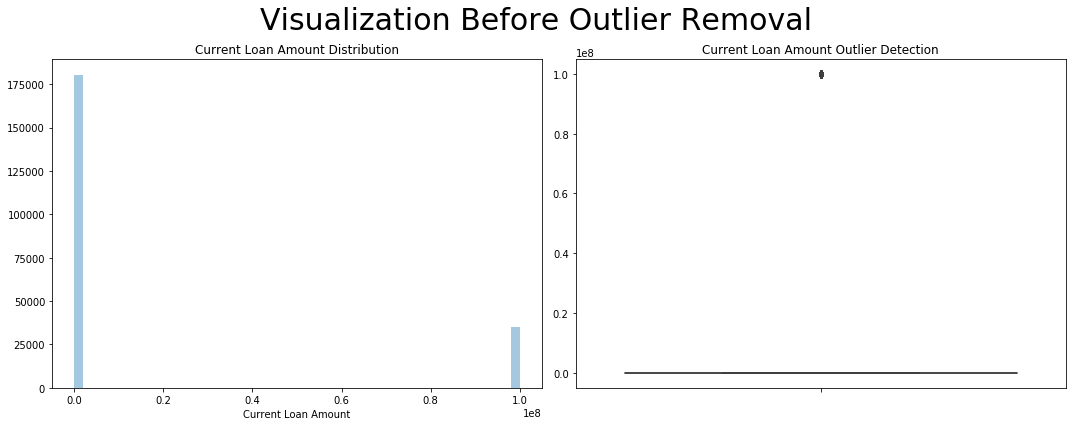

In [27]:
viz(df,'Current Loan Amount','Visualization Before Outlier Removal')

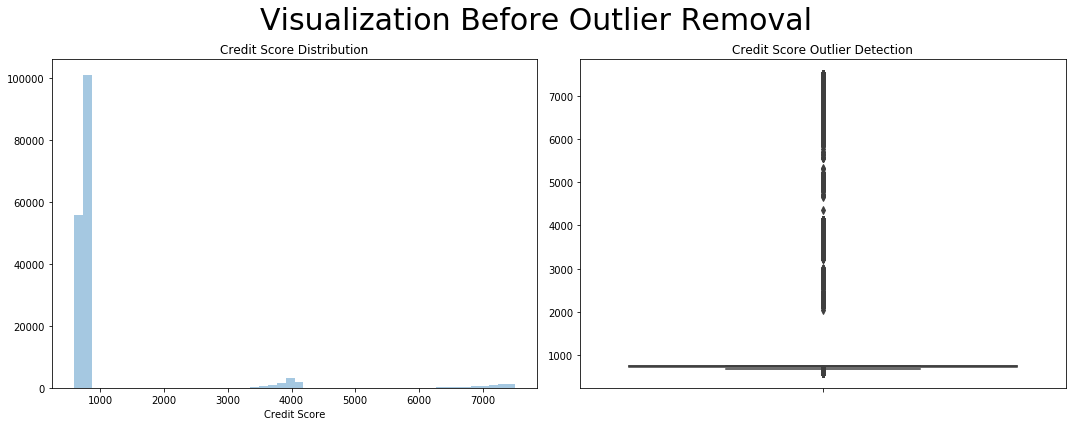

In [28]:
viz(df,'Credit Score','Visualization Before Outlier Removal')

**The extreme values for the "Current Loan Amount" column are converted to null values.**<br>
**The extreme values for the "Credit Score" column are divided by 10.**

In [29]:
df.loc[df['Current Loan Amount'] == df['Current Loan Amount'].max(),'Current Loan Amount'] = np.nan
df['Credit Score'] = df['Credit Score'].apply(lambda x : x / 10 if x > 1000 else x)

# EDA - Exploratory Data Analysis

**The percent of each unique value for the target column "Loan Status" is calculated.**
* _**Analysis: The target column is imbalanced.**_

In [30]:
df['Loan Status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

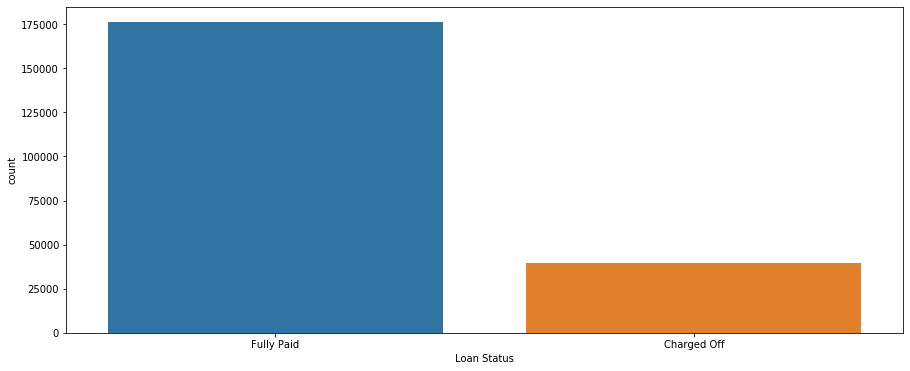

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.countplot(x="Loan Status", data=df)
ax.set_xticks([0,1])
ax.set_xticklabels(['Fully Paid','Charged Off'])
plt.show()

In [32]:
df['Loan Status'].value_counts()

Fully Paid     176191
Charged Off     39509
Name: Loan Status, dtype: int64

In [33]:
print('The percent of "Fully Paid" loans: {:.0%}'.format((len(df[df['Loan Status'] == 'Fully Paid'])/len(df))))
print('The percent of "Charged Off" loans: {:.0%}'.format((len(df[df['Loan Status'] == 'Charged Off'])/len(df))))

The percent of "Fully Paid" loans: 82%
The percent of "Charged Off" loans: 18%


## Missing Values Imputation

**A function that returns a dataframe outlining the percent and number of null values for each column that has null values is introduced.**

In [34]:
def calculate_null (data) :
    null_val = (data.isnull().sum() / len(data)) * 100
    null_data = pd.DataFrame(data = {'null_percent': null_val, 'null_num' : data.isnull().sum()}, index = data.columns)
    null_data = null_data[null_data['null_percent'] != 0]
    return null_data.sort_values(by = 'null_percent',ascending = False) 

In [35]:
calculate_null(df)

,null_percent,null_num
Months since last delinquent,54.827075,118262
Credit Score,20.629578,44498
Annual Income,20.629578,44498
Current Loan Amount,16.323598,35210
Years in current job,4.167826,8990
Bankruptcies,0.209550,452
Tax Liens,0.010199,22
Maximum Open Credit,0.000927,2


**The methods used to impute null values are explained below:**
* _**Column "Months since last delinquent" - More than 50% of the values are missing. The column has been dropped.**_
* _**Column "Bankruptcies" - A little more than 2% have missing values. The rows with missing values have been dropped.**_
* _**Column "Maximum Open Credit" - There are only two missing values. The missing values have been replaced with the column's median value.**_
* _**Column "Years in current job" - There is no sufficient information gained to correctly impute the missing values. A new value is introduced to replace the missing values.**_
* _**Column "Credit Score" - The dataframe is grouped by the unique values from column "Number of Credit Problems," and the credit score median value for each group is used to replace the missing values.**_
* _**Column "Current Loan Amount" - Boxplots are visualized to determine features that will be used to fill in the missing values. The dataframe is then grouped by the unique values from the features, and the current loan amount median value for each group is used to replace the missing value.**_
* _**Column "Annual Income" - Features are used to impute the missing values through regression.**_

In [36]:
df.drop('Months since last delinquent',axis = 1, inplace = True)

In [37]:
df.Bankruptcies.value_counts(dropna = False)

0.000000    192727
1.000000     21506
2.000000       818
nan            452
3.000000       155
4.000000        25
5.000000        13
6.000000         3
7.000000         1
Name: Bankruptcies, dtype: int64

In [38]:
df.dropna(subset = ['Bankruptcies'], axis = 0, inplace = True)

In [39]:
df['Maximum Open Credit'].fillna(df['Maximum Open Credit'].median(),inplace = True)

In [40]:
df['Years in current job'].value_counts(dropna = False)

10 or more years    66628
2 years             19778
less than 1 year    17432
3 years             17388
5 years             14967
1 year              14069
4 years             13601
6 years             12208
7 years             11702
8 years             10224
NaN                  8990
9 years              8261
Name: Years in current job, dtype: int64

In [41]:
df['Years in current job'].replace(np.nan, 'unknown', inplace = True)

In [42]:
df.groupby('Number of Credit Problems')['Credit Score'].median()

Number of Credit Problems
0.000000    731.000000
1.000000    726.000000
2.000000    721.000000
3.000000    720.000000
4.000000    719.000000
5.000000    724.000000
6.000000    733.000000
7.000000    737.000000
8.000000    723.000000
9.000000    718.000000
10.000000   740.000000
11.000000   712.000000
Name: Credit Score, dtype: float64

In [43]:
df['Credit Score'].fillna(df.groupby('Number of Credit Problems')['Credit Score'].transform('median'), inplace = True)

In [44]:
def plot_biboxplot(data,rows,cols,target,col_list) :

    fig,axs = plt.subplots(nrows = rows, ncols = cols, figsize = (15,8))
    
    index = 0

    for i in range(rows) :
        for j in range(cols) :
            sns.boxplot(x = col_list[index],y = target ,data = data, ax = axs[i][j])
            axs[i][j].set_xticklabels(labels = data[col_list[index]].unique(),rotation = 40)
            index += 1
    
    fig.suptitle('Current Loan Amount Median Variation by Nomial Values', fontsize = 30)
    fig.tight_layout(rect = [0,0,1,0.92])

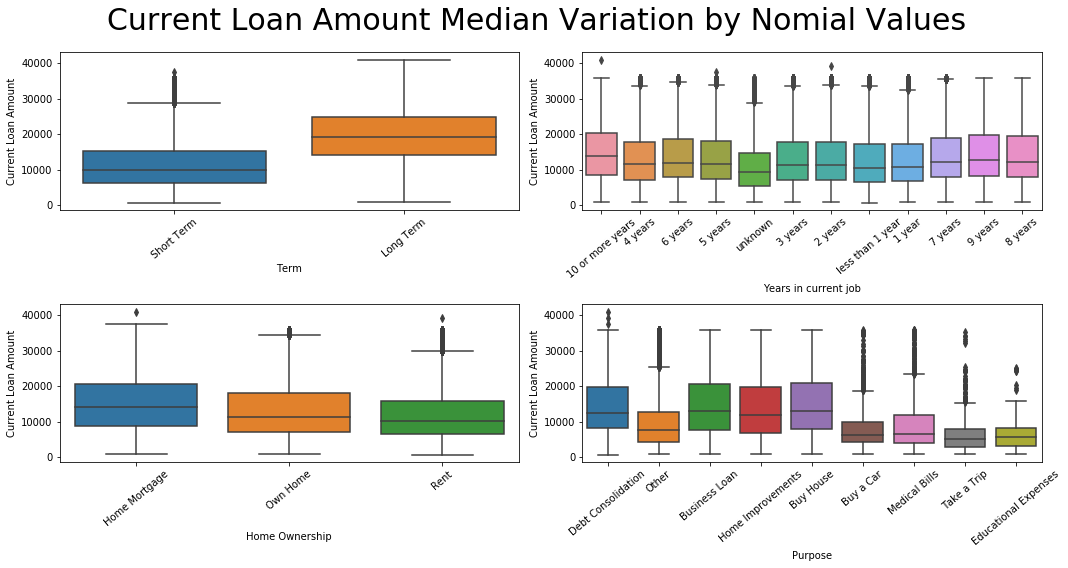

In [45]:
plot_biboxplot(data = df,rows = 2,cols = 2,
            target = 'Current Loan Amount',
            col_list = ['Term','Years in current job','Home Ownership','Purpose'])

In [46]:
df.groupby(['Purpose','Home Ownership','Term'])['Current Loan Amount'].median()

Purpose               Home Ownership  Term      
Business Loan         Home Mortgage   Long Term    21812.000000
                                      Short Term   12266.000000
                      Own Home        Long Term    20418.000000
                                      Short Term   10157.000000
                      Rent            Long Term    17866.000000
                                      Short Term    9878.000000
Buy House             Home Mortgage   Long Term    21683.500000
                                      Short Term   12226.000000
                      Own Home        Long Term    19582.500000
                                      Short Term   13067.000000
                      Rent            Long Term    17831.000000
                                      Short Term    9956.500000
Buy a Car             Home Mortgage   Long Term     8738.000000
                                      Short Term    5953.500000
                      Own Home        Long Term    1007

In [47]:
df['Current Loan Amount'].fillna(df.groupby(['Purpose','Home Ownership','Term'])\
                                            ['Current Loan Amount'].transform('median'), inplace = True)

#### Imputing Null Values Through Regression

In [48]:
train = df[df['Annual Income'].notnull()]
test = df[df['Annual Income'].isnull()]
train.shape,test.shape

((170837, 16), (44411, 16))

In [49]:
#Returns a list of column names that were over the correlation threshold for target column
def correlatedColumns(data,col, threshold) :
    feature_list = []
    corr_data = abs(data.corr()[col])
    
    for ind in corr_data.index :
        if corr_data[ind] >= threshold :
            feature_list.append(ind)
    return feature_list
        

In [50]:
corr_list = correlatedColumns(train,'Annual Income',0.30)
corr_list

['Current Loan Amount',
 'Annual Income',
 'Monthly Debt',
 'Current Credit Balance']

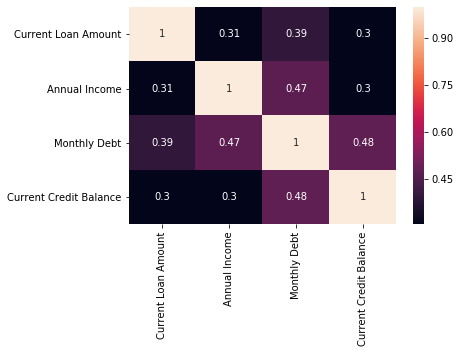

In [51]:
sns.heatmap(train[corr_list].corr(),annot = True)
plt.show()

In [52]:
num_list = ['Current Loan Amount','Monthly Debt','Current Credit Balance']

In [53]:
def best_transformation(data, col) :
    copy_df = data.copy()
    series = copy_df.loc[:,col]
    trans_data = stats.boxcox(series+1)
    
    
    fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2, figsize = (15,6))
    
    
    plt.suptitle('Transformation of column: {}'.format(col), fontsize = 15, fontweight = 'bold')
    
    sns.distplot(series, ax = ax1)
    sns.distplot(trans_data[0], ax = ax2)
    
    ax1.set_xlabel('Before Transformation', fontsize = 12)
    ax2.set_xlabel('After Transformation', fontsize = 12)
    
    plt.show()
    
    print('Best power value: {:.2f}'.format(trans_data[1]))
    
    #CLT is reference to central limit theorem
    CLT_before_list = [stats.skew(series),stats.kurtosis(series),np.mean(series),np.median(series)]
    CLT_after_list = [stats.skew(trans_data[0]),
                      stats.kurtosis(trans_data[0]),
                      np.mean(trans_data[0]),
                      np.median(trans_data[0])]
    
    CLT_before_series = pd.Series(CLT_before_list, index = ['Skew','Kurtosis','Mean','Median'])
    CLT_after_series = pd.Series(CLT_after_list, index = ['Skew','Kurtosis','Mean','Median'])
    
    merged_data = pd.concat([CLT_before_series,CLT_after_series],axis = 1)
    merged_data.rename(columns = {0:'Before Transformation', 1 : 'After Transformation'},inplace = True)
    return merged_data
    
    

    
    

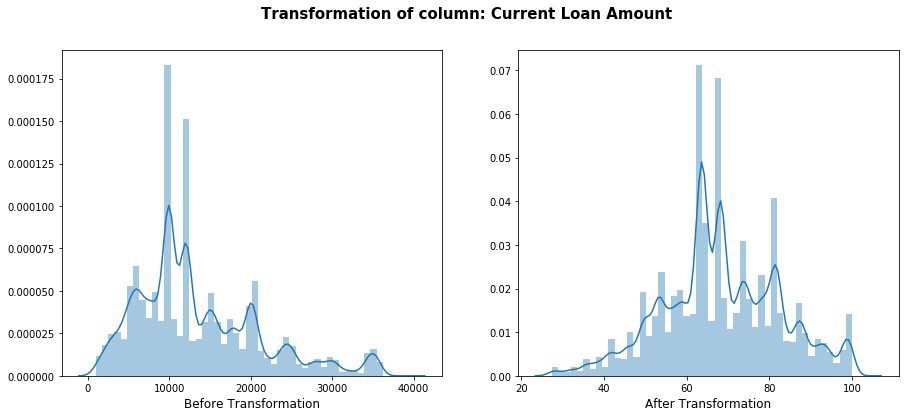

Best power value: 0.34


,Before Transformation,After Transformation
Skew,0.947146,-0.007971
Kurtosis,0.528968,-0.145146
Mean,13491.596683,68.199396
Median,12020.000000,68.027010


In [54]:
best_transformation(train,'Current Loan Amount')

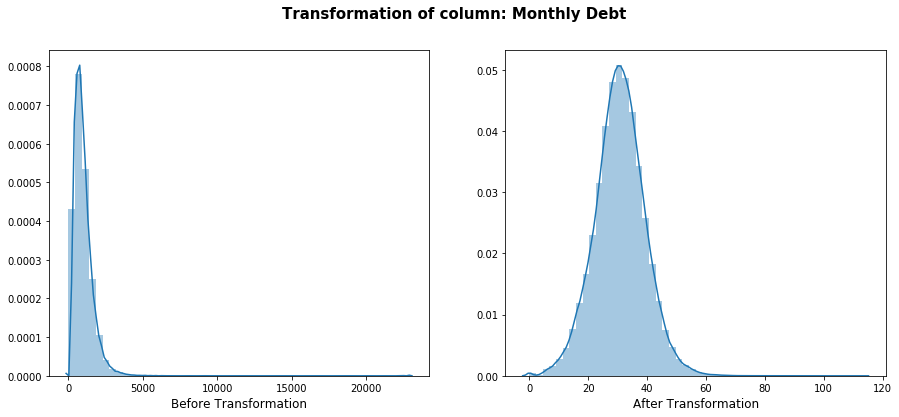

Best power value: 0.38


,Before Transformation,After Transformation
Skew,2.051819,0.048793
Kurtosis,16.605458,0.647887
Mean,960.422995,30.748301
Median,841.010000,30.760784


In [55]:
best_transformation(train,'Monthly Debt')

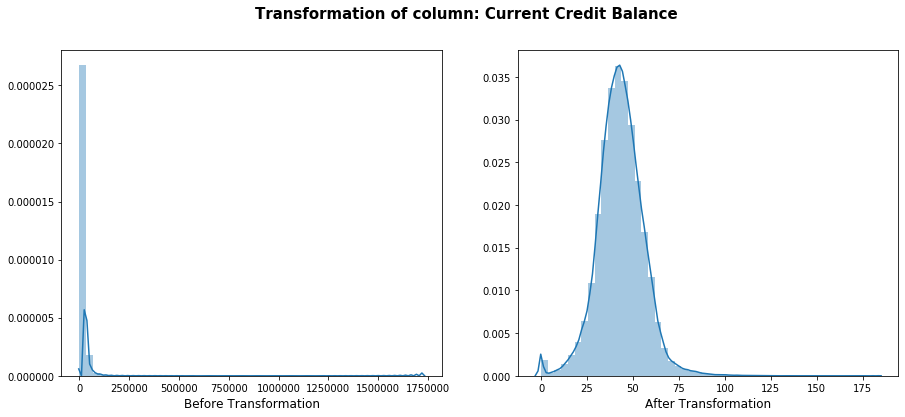

Best power value: 0.27


,Before Transformation,After Transformation
Skew,12.530417,0.190359
Kurtosis,547.007064,2.322542
Mean,15401.056341,43.191468
Median,11040.000000,42.942675


In [56]:
best_transformation(train,'Current Credit Balance')

In [57]:
for col in num_list :
    train[col],fitted_lambda = stats.boxcox(train[col]+1)
    test[col] = stats.boxcox(test[col]+1,fitted_lambda)

In [58]:
df_copy = pd.concat([train,test],sort = False, ignore_index = True)
df_imp = df_copy[corr_list+['Term','Years in current job','Home Ownership','Purpose']]

In [59]:
def impute_val(data, target) :
    data = pd.get_dummies(data, drop_first = True)
    
    filled = data[data[target].notnull()]
    missing = data[data[target].isnull()]
    missing.drop(target,axis = 1, inplace = True)
    
    X = filled.drop(target,axis = 1)
    y = filled[target]
    
    scaler = MinMaxScaler()
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 0)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    L = LinearRegression()
    L.fit(X_train,y_train)
    
    print('r2 score is:',r2_score(y_test,L.predict(X_test)))
    print('RMSE score is:', mean_squared_error(y_test,L.predict(X_test)) **.5)
    print('\n')
    
    X = scaler.fit_transform(X)
    missing = scaler.transform(missing)
    L.fit(X,y)
    prediction = L.predict(missing)
    df.loc[df[target].isnull(),target] = prediction
    
    print('The number of null values for column-{} is {}.'.format(target,df[target].isnull().sum()))
    

In [60]:
impute_val(df_imp,'Annual Income')

r2 score is: 0.2133697823981081
RMSE score is: 52866.29262817418


The number of null values for column-Annual Income is 0.


## Feature Engineering

**Three new features that will help with loan status prediction are created.**
* _**Credit Utilization**_
* _**Debt to Income Ratio**_
* _**Credit Remaining**_

In [61]:
df['Credit Utilization'] = [(df.iloc[i,7] / (df.iloc[i,8]+1)) for i in range(len(df))]
df['Debt to Income'] = [(df.iloc[i,3] / ((df.iloc[i,2]/12)+1)) for i in range(len(df))]
df['Credit Remaining'] = [df.iloc[i,8] - df.iloc[i,7] for i in range(len(df))]

## Encoding

**The target variable and nomial independent variables are encoded to numbers.**

In [62]:
df['Loan Status'] = df['Loan Status'].map({'Fully Paid' : 0,'Charged Off' : 1})

In [63]:
df = pd.get_dummies(df,drop_first = True)

## Model Selection

**The dataframe without the target variable is assigned to X and the target column is assigned to y.**<br>
**X and y are then split into train and validation sets.**<br>
**Various paramters are used for different algorithms to determine the best model.** 

In [64]:
X = df.drop('Loan Status',axis = 1)
y = df['Loan Status']
X.shape,y.shape

((215248, 36), (215248,))

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.80, random_state = 5, stratify = y)

In [66]:
class_weight = y_train.value_counts()[0]/y_train.value_counts()[1]
print('Class weight = {:.2f}'.format(class_weight))
weight_dict = {0 : 1.0, 1 : class_weight}

Class weight = 4.46


#### Logistic Regression

In [67]:
lr_grid = {'penalty' : ['l1','l2','elasticnet'],
           'C' : [0.01,0.1,1,10,100],
           'class_weight' : [weight_dict,'balanced']}

lr = GridSearchCV(estimator = LogisticRegression(),
                 param_grid = lr_grid,
                 scoring = 'roc_auc',
                 cv = 3,
                 n_jobs = -1)

lr.fit(X_train,y_train)

print('Training done.')

Training done.


#### Random Forest Classifier

In [68]:
rf_grid = {'max_depth' : range(2,6),
           'min_samples_split' : range(10,21,2),
           'max_features' : [0.4,0.5,0.6,'sqrt'],
           'class_weight' : [None,weight_dict,'balanced','balanced_subsample'],
           'max_samples' : [None, 0.5, 0.75]}

rf = RandomizedSearchCV(RandomForestClassifier(n_estimators = 1000),
                        param_distributions = rf_grid,
                        scoring = 'roc_auc',
                        cv = 3,
                        n_iter = 10,
                        n_jobs = -1)
rf.fit(X_train,y_train)

print('Training done.')

Training done.


#### Gradient Boosting Classifier

In [69]:
gb_grid = {'learning_rate' : [0.05,0.1,0.2,0.3,0.4],
           'n_estimators' : [200,500,1000,1250],
           'min_samples_split' : range(10,21,2),
           'max_depth' : range(2,6),
           'max_features' : [0.4,0.5,0.6,'sqrt'],
           'subsample' : [0.5,0.75,1.0]}

gb = RandomizedSearchCV(GradientBoostingClassifier(),
                        param_distributions = gb_grid,
                        scoring = 'roc_auc',
                        cv = 3,
                        n_iter = 10,
                        n_jobs = -1)
gb.fit(X_train,y_train)

print('Training done.')

Training done.


#### Extreme Gradient Boosting Classifier

In [70]:
xg_grid = {'learning_rate': [0.05,0.1,0.2,0.3,0.4],
           'n_estimators' : [200,500,1000,1250],
           'max_depth' : range(2,6),
           'min_child_weight' : [2,3,4,5],
           'subsample' : [0.5,0.75,1.0],
           'colsample_bytree' : [0.4,0.5,0.6,'sqrt'],
           'scale_pos_weight' : [class_weight - 1, class_weight, class_weight + 1]}

xg = RandomizedSearchCV(XGBClassifier(),
                        param_distributions = xg_grid,
                        scoring = 'roc_auc',
                        cv = 3,
                        n_iter = 10,
                        n_jobs = -1)
xg.fit(X_train,y_train)

print('Training done.')

Training done.


**The receiving operating characteristic curve is visualized to determine the best model.**

In [71]:
def plot_roc_auc(dictionary) :
    opacity = 0.3
    
    plt.figure(figsize = (8,8))
    plt.plot([0,1],[0,1], linestyle = '--', label = 'No Skill')
    
    for name,alg in dictionary.items():
        proba = alg.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_test,proba).round(decimals = 5)
        fpr,tpr,_ = roc_curve(y_test,proba)
        plt.plot(fpr, tpr, linewidth = 2, label = name + ' ROC: ' + str(score), alpha = opacity)
        opacity += 0.2
    
    plt.xlim(-0.025,1.025)
    plt.ylim(-0.025,1.025)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    
    plt.grid(linestyle = '--')
    
    plt.legend()
    
    plt.suptitle('Receiving Operating Characteristic Area Under the Curve', fontsize = 30)
    plt.tight_layout(rect = [0,0,1,0.90])

In [72]:
clfs_dict = {'Logistic Regression' : lr,
             'Random Forest Classifier' : rf,
             'Gradient Boosting Classifier' : gb,
             'Extreme Gradient Boosting Classifier' : xg}

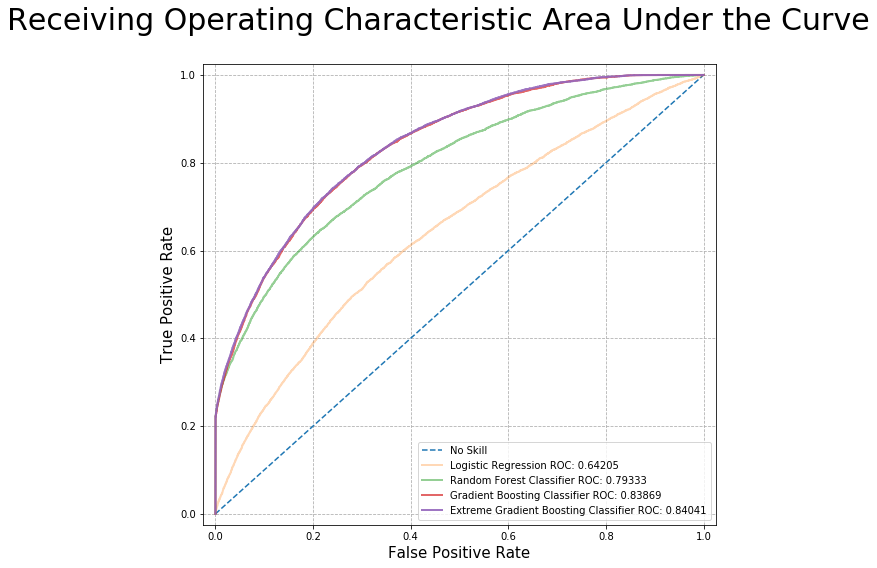

In [73]:
plot_roc_auc(clfs_dict)

**After choosing the optimal model, the train and test scores between various metrics are compared to ensure the model is not underfitting or overfitting.**

In [74]:
clf = xg.best_estimator_

In [75]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [76]:
def metric_df(X_train,X_test,train_pred,test_pred) :
    train_list = []
    test_list = []
    
    train_list.append(accuracy_score(y_train,train_pred))
    train_list.append(recall_score(y_train,train_pred))
    train_list.append(precision_score(y_train,train_pred))
    train_list.append(f1_score(y_train,train_pred))
    
    test_list.append(accuracy_score(y_test,test_pred))
    test_list.append(recall_score(y_test,test_pred))
    test_list.append(precision_score(y_test,test_pred))
    test_list.append(f1_score(y_test,test_pred))
            
    metric = pd.DataFrame(data = [train_list,test_list],
                        columns = ['accuracy','recall_score','precision_score','f1_score'],
                        index = ['train','test'])
    return metric.T
    

In [77]:
metric_df(X_train,X_test,y_train_pred,y_test_pred)

,train,test
accuracy,0.793267,0.771475
recall_score,0.790263,0.715735
precision_score,0.462440,0.426327
f1_score,0.583457,0.534362


## Business Decision

**The threshold is adjusted to return the maximum F1 score for the model.**
* _**Note: F1 score is used as the metric assuming the opportunity-loss due to false positives is equal to the real-loss due to false negatives. If revenue loss due to defaulted loans outweigh profit gained from fully paid loans, then the threshold should be adjusted so that the number of false negatives is minimized while retaining a low number of false positive . Conversely, if profit gained from fully paid loans outweigh revenue loss due to defaulted loans, then the threshold should be adjusted so that the number of false positives is minimized while retaining a low number of false negative.**_

In [78]:
proba = clf.predict_proba(X_test)[:,1]
fpr,tpr,thresholds = roc_curve(y_test,proba)

In [79]:
def best_f1(prob_pred,thresholds):
    f1_list = []
    for thresh in thresholds:
        pred = np.where(prob_pred > thresh,1,0)
        f1_list.append(f1_score(y_test,pred))
        
    f1_df = pd.DataFrame(data = {'threshold' : thresholds,
                                 'f1_score' : f1_list})
    opt_thresh = f1_df.loc[f1_df['f1_score'] == f1_df['f1_score'].max(),'threshold'].values
    y_pred = np.where(prob_pred > opt_thresh,1,0)
    
    return y_pred

In [80]:
final_pred = best_f1(proba,thresholds)

In [81]:
def final_df(test,pred) :
    final_list = []
    
    final_list.append(accuracy_score(test,pred))
    final_list.append(recall_score(test,pred))
    final_list.append(precision_score(test,pred))
    final_list.append(f1_score(test,pred))
    
    final = pd.DataFrame(data = [final_list],
                        columns = ['accuracy','recall_score','precision_score','f1_score'],
                        index = ['final_score'])
    
    return final.T

In [82]:
final_df(y_test,final_pred)

,final_score
accuracy,0.818165
recall_score,0.598707
precision_score,0.503143
f1_score,0.546781


In [83]:
def plot_cm(test,pred):
    cm_reg = confusion_matrix(test,pred)
    cm_norm = confusion_matrix(test,pred,normalize = 'true')
    
    fig, axs = plt.subplots(ncols = 2, figsize = (14,6))
    
    sns.heatmap(cm_reg, annot = True,cmap = 'Blues', fmt = 'g', cbar = False, ax = axs[0])
    axs[0].set_xticklabels(['Fully Paid','Charged Off'], rotation = 40)
    axs[0].set_yticklabels(['Fully Paid', 'Charged Off'], rotation = 0)
    axs[0].set_xlabel('Predicted Label', fontsize = 15)
    axs[0].set_ylabel('True Label',fontsize = 15)
    axs[0].set_title('Confusion Matrix Real Values', fontsize = 20)
    
    sns.heatmap(cm_norm, annot = True,cmap = 'Blues', fmt = '.2g', cbar = False, ax = axs[1])
    axs[1].set_xticklabels(['Fully Paid','Charged Off'], rotation = 40)
    axs[1].set_yticklabels(['Fully Paid', 'Charged Off'], rotation = 0)
    axs[1].set_xlabel('Predicted Label', fontsize = 15)
    axs[1].set_ylabel('True Label',fontsize = 15)
    axs[1].set_title('Confusion Matrix Normalized Values', fontsize =  20)
    
    fig.tight_layout()

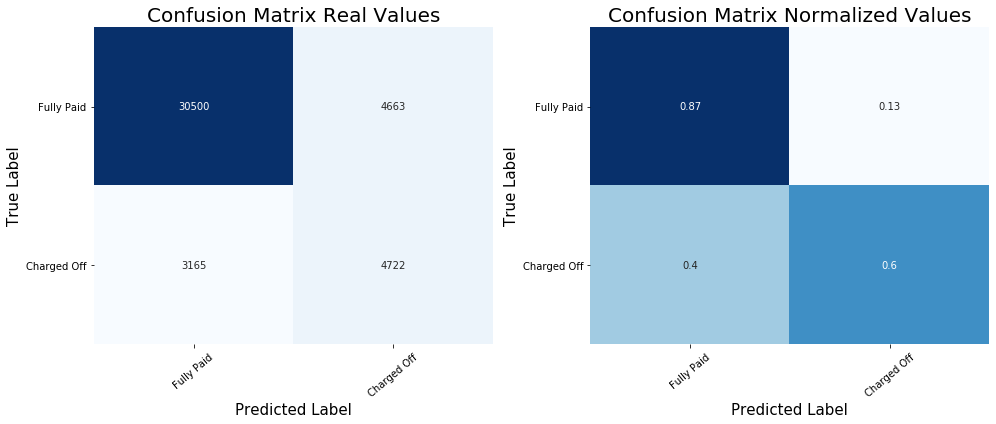

In [84]:
plot_cm(y_test,final_pred)

**A bar graph is visualized to outline the top five features for predicting loan status.**

In [85]:
def imp_features(alg) :
    importance = pd.DataFrame(data = alg.feature_importances_, index = X.columns, columns = ['importance'])
    importance = importance.sort_values(by = 'importance',ascending = False).head()
    return importance

In [86]:
imp_features_df = imp_features(clf)
imp_features_df

,importance
Credit Score,0.294868
Term_Short Term,0.175320
Current Loan Amount,0.083375
Years in current job_unknown,0.037741
Number of Credit Problems,0.033929


In [87]:
def plot_imp_features() :
    fig,ax = plt.subplots(figsize = (15,6))

    ax.bar(x = imp_features_df.index,height = imp_features_df.importance.values)
    ax.set_xticklabels(labels = imp_features_df.index, rotation = 40)

    ax.set_title('Top Five Imporant Features', fontsize = 30)
    fig.tight_layout(rect = [0,0,1,0.88])

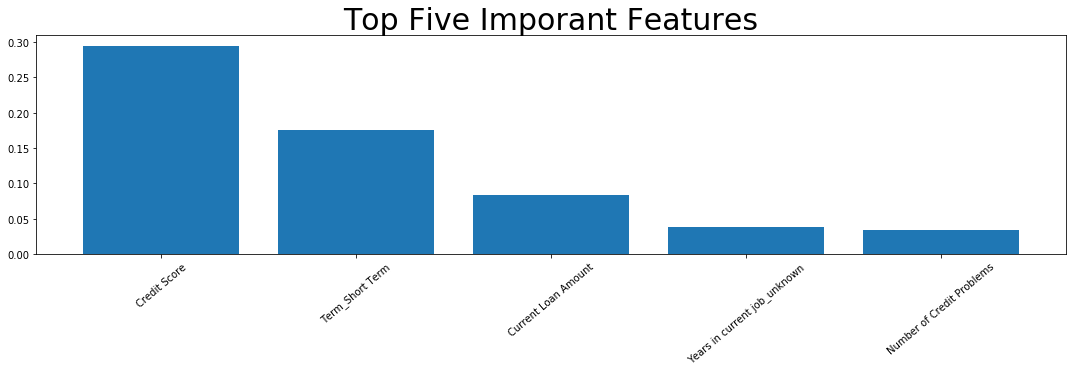

In [88]:
plot_imp_features()

**Based on the top five features, the following questions should be asked to a customer applying for a loan:**
1. _**What is your credit score?**_
2. _**Are you applying for a short or long term loan?**_
3. _**What is the amount you are trying to borrow?**_
4. _**How many years have you been in your current job?**_
5. _**How many credit issues did you have in the past?**_
